In [103]:
import numpy as np
import pandas as pd
import datetime
import xarray as xr
import rioxarray
import geopandas as gpd
from pyproj import Transformer
import ProcessSERAC
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline


In [116]:
## File directory

SERAC_dir = "/Users/huigao/Desktop/Mass_reconstruction/Annual_thickness_reconstruction/Partition_SERAC2022/"
IS2_dir = "/Users/huigao/Documents/Python_notebooks/202205_ICESat-2_seasonality/Data/"

SERAC = ProcessSERAC.Read(SERAC_dir, 6)

header, df = SERAC.return_raw()

In [153]:
X = []
Y = []
transformer = Transformer.from_crs("epsg:4326", "epsg:3413", always_xy=True)

for i in range(len(header)):
    x_source = header.iloc[i,10]
    y_source = header.iloc[i,11]
    x, y = transformer.transform(x_source, y_source)
    X.append(x)
    Y.append(y)

header['X'] = X
header['Y'] = Y

header.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,X,Y
0,6000001,12,0,856134.210,7792839.790,1827.438,895.62,1.296,1.045,83020,-29.639932452723677,69.99602461491223,56.27309976196289,579664.776251,-2.110203e+06
1,6000006,38,0,538995.39,7700475.85,3044.616,4977.06,0.087,0.085,83020.0,-38.006373,69.41071,49.0734,274411.529821,-2.236960e+06
2,6000008,33,0,1015853.26,7778996.15,947.344,88.11,1.061,1.049,83020.0,-25.641842,69.609362,58.996,739691.358127,-2.105374e+06
3,6000018,37,0,964439.41,7744848.36,2163.16,1703.75,0.232,0.228,83020.0,-27.104913,69.404938,59.919199,692712.532949,-2.145308e+06
4,6000020,33,0,516611.54,7740277.67,3046.801,6049.86,0.05,0.049,83020.0,-38.569554,69.769952,47.841001,247916.663969,-2.199674e+06


In [118]:
# Read in the ATL14&15 data
atl14 = xr.open_dataset(IS2_dir +"/ATL14_GL_0311_100m_001_01.nc")
atl15 = xr.open_dataset(IS2_dir +"/ATL15_GL_0311_01km_001_01.nc", group="delta_h")

In [134]:
# Buffer selected SERAC reconstructions with a distance (buffer_dis) and extract bounding box
def buffer_points(pts, buffer_dis):
    aoi_bound_x = [min(pts[:,0])-buffer_dis, max(pts[:,0])+buffer_dis]
    aoi_bound_y = [min(pts[:,1])-buffer_dis, max(pts[:,1])+buffer_dis]
    return aoi_bound_x, aoi_bound_y

# Crop ATL raster product using the bounding box
def crop_atl_raster(atl_h, pts, buffer_dis):
    aoi_bound_x, aoi_bound_y = buffer_points(pts, buffer_dis)
    atl_h = atl_h.rio.write_crs("EPSG:3413", inplace=True)
    atl_h = atl_h.rio.clip_box(
        minx=aoi_bound_x[0],
        miny=aoi_bound_y[0],
        maxx=aoi_bound_x[1],
        maxy=aoi_bound_y[1]
    )
    return atl_h

In [155]:
buffer_dis = 20000 # Buffer distance (m)

# Define default locations for extracting time series
pts_loc = np.array([[-199638, -2169482],
                   [-188005, -2177025],
                   [-200909, -2187151],
                   [-197017, -2199723]])

use_default = False

if not use_default:
    SERAC_id = header.iloc[:,0].values
    id_input_list = input('Enter the SERAC ID (seperate by space if entering multiple IDs): ')
    buffering = input('Enter the buffering distance (m) for selection of time series (leave this empty if only want to use the IDs provided): ')

    if buffering:
        buffer_dis = int(buffering)
        
    id_input_list = id_input_list.split()

    header_sel = pd.DataFrame()
    id_valid = []
    for id_input in id_input_list:  
        if id_input not in SERAC_id:
            print(id_input+' does not exist and is removed.')
        else:
            id_valid.append(id_input)
            header_sel = pd.concat([header_sel, header[header.iloc[:, 0] == id_input]])

    if id_valid:
        header_sel = header_sel.reset_index(drop = True)
        pts_loc = np.array([header_sel['X'].values, header_sel['Y'].values]).T
    else:
        print('None of the IDs provided exist, will use the default locations.')
        use_default = True
        
if use_default or buffering:
    aoi_bound_x, aoi_bound_y = buffer_points(pts_loc, buffer_dis)
    x_sel = (header['X'].values > aoi_bound_x[0]) & (header['X'].values < aoi_bound_x[1])
    y_sel = (header['Y'].values > aoi_bound_y[0]) & (header['Y'].values < aoi_bound_y[1])

    pts_sel_SERAC = np.logical_and(x_sel, y_sel)
    header_sel = header[pts_sel_SERAC].reset_index(drop = True)

Enter the SERAC ID (seperate by space if entering multiple IDs):  6000008
Enter the buffering distance (m) for selection of time series (leave this empty if only want to use the IDs provided):  2000


In [156]:
## Extract time series

atl14_h_aoi = crop_atl_raster(atl14[['h']], pts_loc, buffer_dis)
atl15_h_aoi = crop_atl_raster(atl15[['delta_h']], pts_loc, buffer_dis)


h_atl1415 = []
h1_atl1415 = []
time_SERAC = []
absh_SERAC = []
dynh_SERAC = []
x_err = []
y_err = []
ts_atl14_dh_l = []
ts1_atl14_dh_l = []

# Find the position of the k nearest elements in a 1d array to a value
def find_nearest(array, value, k):
    array = np.asarray(array)
    idx = np.argpartition(np.abs(array - value), tuple(range(0,k)))
    return idx[:k]

for i in range(len(header_sel)):
    ind_x_atl15 = find_nearest(atl15['x'].values, header_sel['X'][i], 1).item()
    ind_y_atl15 = find_nearest(atl15['y'].values, header_sel['Y'][i], 1).item()
    x_err.append(atl15['x'].values[ind_x_atl15] - header_sel['X'][i])
    y_err.append(atl15['y'].values[ind_y_atl15] - header_sel['Y'][i])
    
    ts_atl14_dh = atl14_h_aoi.sel(x=header_sel['X'][i], y=header_sel['Y'][i], method="nearest")
    ts1_atl14_dh = atl14_h_aoi.sel(x=atl15['x'].values[ind_x_atl15], y=atl15['y'].values[ind_y_atl15], method="nearest")
    ts_atl14_dh_l.append(ts_atl14_dh['h'].values)
    ts1_atl14_dh_l.append(ts1_atl14_dh['h'].values)
    ts_atl15_dhdt = atl15_h_aoi.sel(x=header_sel['X'][i], y=header_sel['Y'][i], method="nearest")

    h_atl1415.append(ts_atl14_dh['h'].values+ts_atl15_dhdt['delta_h'].values)
    h1_atl1415.append(ts1_atl14_dh['h'].values+ts_atl15_dhdt['delta_h'].values)

    SERAC_id = header_sel.iloc[i, 0]
    time_SERAC.append(df[SERAC_id][2].values)
    absh_SERAC.append(df[SERAC_id][7].values)
    dynh_SERAC.append(df[SERAC_id][12].values)

SERAC_atl15_dis = np.sqrt(np.array(x_err)**2 + np.array(y_err)**2)
# print("Distance between SERAC time series and closest ATL15 product (m): \n", SERAC_atl15_dis)    
    


# Datetime to decimal year
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

time_atl15 = []
for time in atl15_h_aoi['time'].values:
    time_atl15.append(year_fraction(pd.Timestamp(time).to_pydatetime()))

/Users/huigao/opt/anaconda3/lib/python3.8/site-packages/rasterio/windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


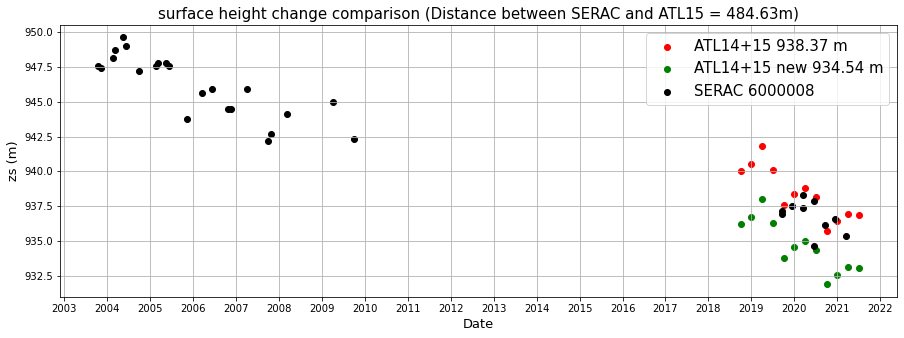

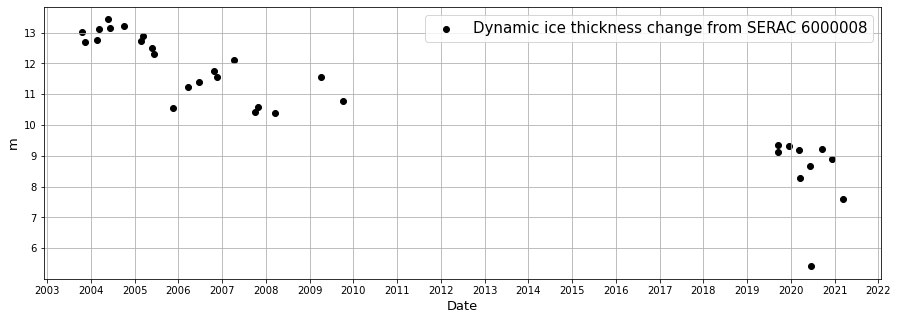

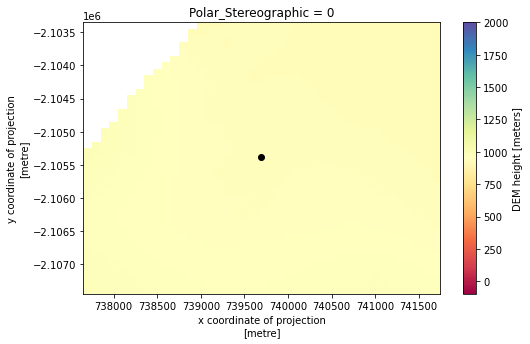

In [157]:
## Plot 

rand_plot = False
k = 10 
if len(absh_SERAC)>k:
    if rand_plot:
        # examp_plot_id = np.argpartition(header_sel['X'].values, tuple(range(0,k)))[:k] # Points with smallest "X"
        examp_plot_id = np.sort(np.random.permutation(len(header_sel))[:k])
    else:
        examp_plot_id = range(k)
else:
    examp_plot_id = range(len(absh_SERAC))

for i in examp_plot_id:
    fig, ax = plt.subplots(figsize = (15,5))
    ax.scatter(time_atl15, h_atl1415[i], c = 'r', label = 'ATL14+15 ' + str(np.round(ts_atl14_dh_l[i], 2)) + ' m')
    ax.scatter(time_atl15, h1_atl1415[i], c = 'g', label = 'ATL14+15 new ' + str(np.round(ts1_atl14_dh_l[i], 2)) + ' m')
    
    msk_SERAC = time_SERAC[i]>1990
    time_msked = time_SERAC[i][msk_SERAC]
    ax.scatter(time_msked, absh_SERAC[i][msk_SERAC], c = 'k', label = 'SERAC '+header_sel.iloc[i, 0])
    ax.set_xticks(np.arange(int(time_msked[0]), 2023, 1))
    ax.set_xlabel('Date',fontsize = 13)
    ax.set_ylabel('zs (m)', fontsize=13)
    ax.set_title('surface height change comparison (Distance between SERAC and ATL15 = '+str(np.round(SERAC_atl15_dis[i],2))+'m)', fontsize=15)
    ax.legend(fontsize=15)
    ax.grid(True)
    
    fig, ax = plt.subplots(figsize = (15,5))
    ax.scatter(time_msked, dynh_SERAC[i][msk_SERAC], c = 'k', label = 'Dynamic ice thickness change from SERAC '+header_sel.iloc[i, 0])
    ax.set_xticks(np.arange(int(time_msked[0]), 2023, 1))
    ax.set_xlabel('Date',fontsize = 13)
    ax.set_ylabel('m', fontsize=13)
    ax.legend(fontsize=15)
    ax.grid(True)
    
    fig = plt.subplots(figsize = (8,5))
    atl14_h_aoi.h.plot(cmap="Spectral", vmin=-100, vmax=2000)
    plt.scatter(header_sel['X'].values[i], header_sel['Y'].values[i], c = 'k')
    plt.show()

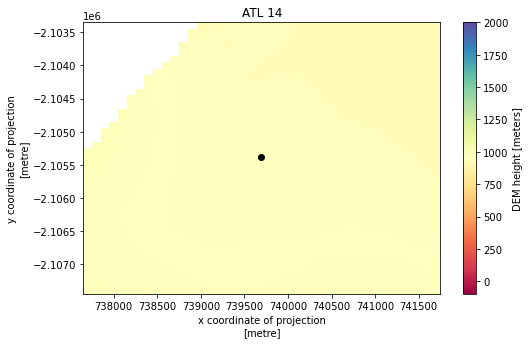

In [158]:
fig = plt.subplots(figsize = (8,5))
atl14_h_aoi.h.plot(cmap="Spectral", vmin=-100, vmax=2000)
plt.scatter(header_sel['X'].values, header_sel['Y'].values, c = 'k')
plt.title('ATL 14')
plt.show()

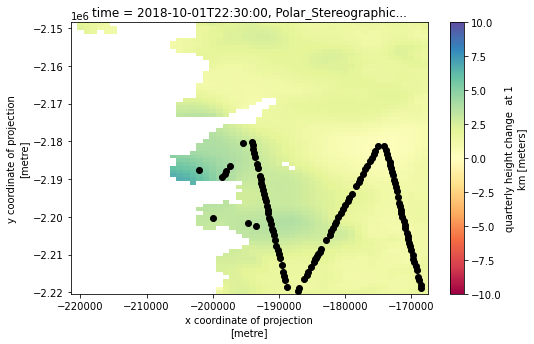

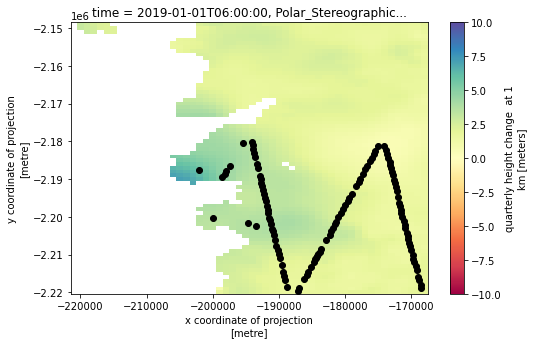

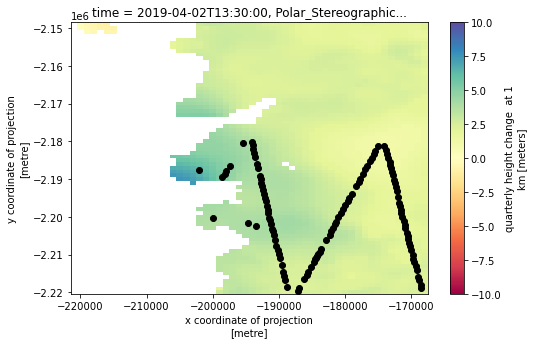

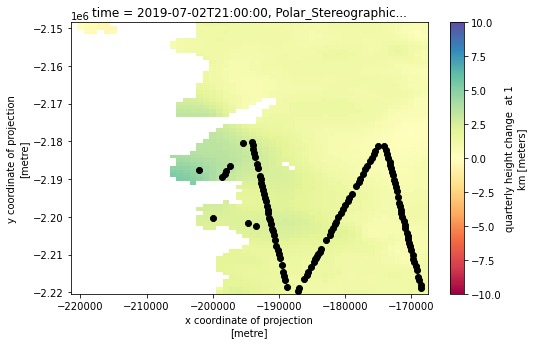

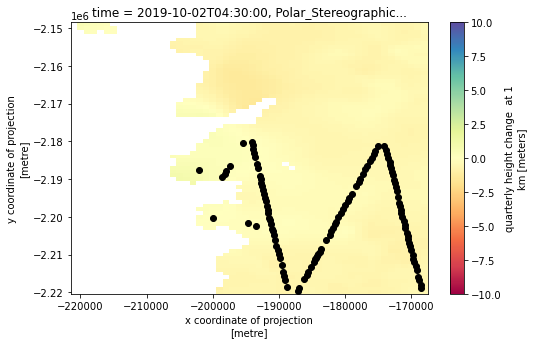

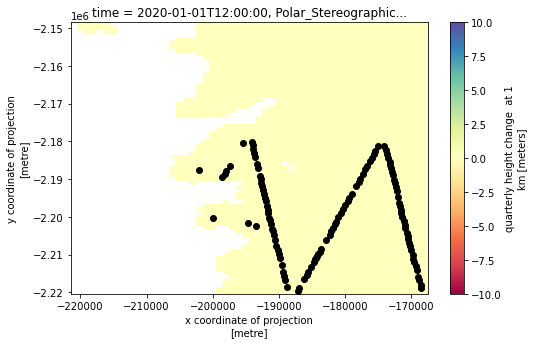

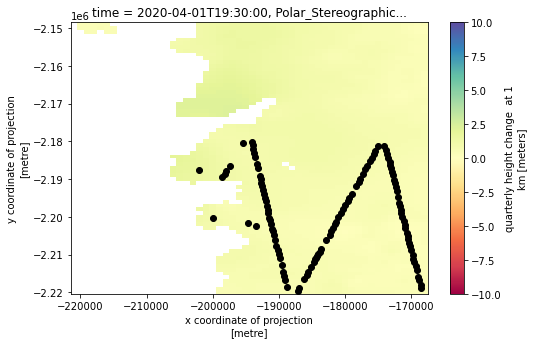

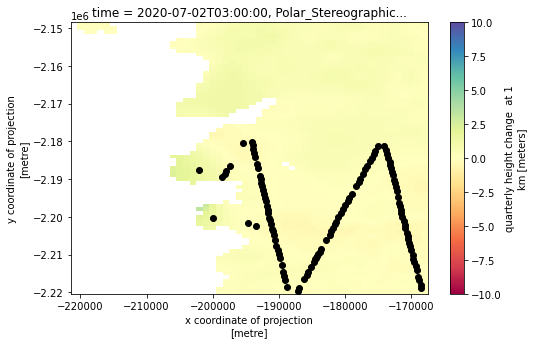

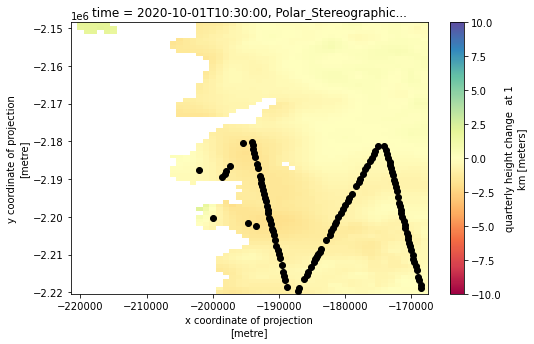

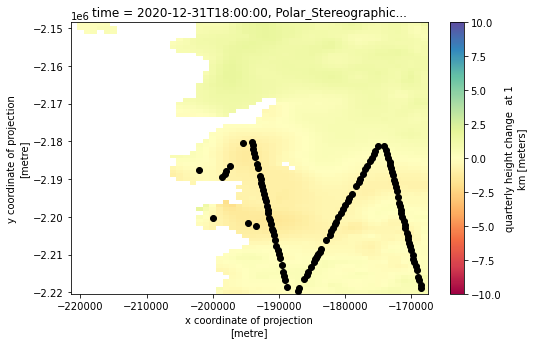

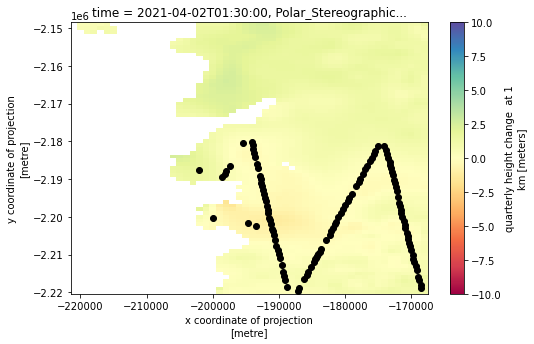

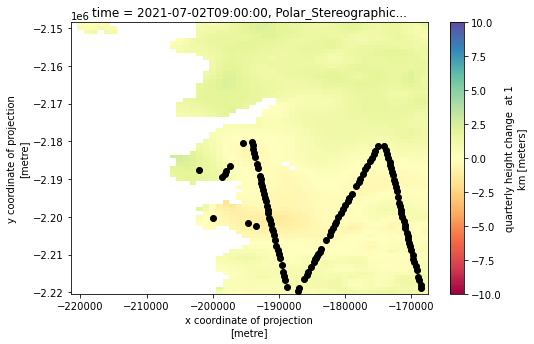

In [130]:
for i in range(len(atl15_h_aoi['time'])):
    fig = plt.subplots(figsize = (8,5))
    fig_atl15 = atl15_h_aoi.delta_h[i,:,:].plot(cmap="Spectral")
    fig_atl15.set_clim(vmin=-10, vmax=10)

    plt.scatter(header_sel['X'].values, header_sel['Y'].values, c = 'k')
    plt.show()